In [11]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams['savefig.dpi'] = 300
# mpl.rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath, amsfonts}"]

In [13]:
import torch
from torch import nn
import sbi
from sbi import utils as utils
from sbi.inference import likelihood_estimator_based_potential

In [14]:
from tools.catalog import Catalog
from tools.plot_tools import binned_plot
get_cen = lambda edges: np.array([(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)])

# UchuuUM old

## Load and cut

In [11]:
cat = Catalog().load('data/raw/UchuuUM_sn40_z=0.49-0.494_sm9.5-extralarge_221020_contam.p')

# only rotation 0
rot = 0
cat = cat[(cat.prop['rotation']==rot).values]

Loading catalog from: data/raw/UchuuUM_sn40_z=0.49-0.494_sm9.5-extralarge_221020_contam.p


In [12]:
# load additional properties
props = pd.read_csv('data/raw/halodir_040_m200c1e13_props.csv').drop('Unnamed: 0', axis=1)
props = props.set_index('id')

props = props.reindex(cat.prop['id']).reset_index()

# append additional properties
for c in props.columns:
    if c not in cat.prop.columns:
        cat.prop[c] = props[c]
        
cat.prop['conc'] = cat.prop['Rvir']/cat.prop['rs']
cat.prop['logM'] = np.log10(cat.prop['M200c'])

In [13]:
# cut clusters
mask = cat.prop['M200c'].values >= 1e14
mask = mask & (cat.prop['conc'].values <= 15)
cat = cat[mask]

In [14]:
# cut galaxy sample
vcut = 3785
aperture = 2.3
Ngal_samp = 10

# cylinder cut
for i in range(len(cat)):
    mask = np.abs(cat.gal[i]['vlos']) < vcut
    mask = mask & (cat.gal[i]['Rproj'] < 2.3)
    cat.gal[i] = cat.gal[i][mask]
    cat.prop.loc[i, 'Ngal'] = len(cat.gal[i])
    # TODO: recalculate sigv
cat.par['aperture']=aperture
cat.par['vcut']=vcut

print(len(cat))
cat = cat[cat.prop['Ngal'].values>=10]
print(len(cat))

# now, limit the spectroscopic sampling
for i in range(len(cat)):
    mask = np.random.choice(len(cat.gal[i]), size=Ngal_samp, replace=False)
    cat.gal[i] = cat.gal[i][mask]

71721
71721


## prepare

In [15]:
ids = cat.prop['id'].values.astype(np.int64)
ids

array([129261409195131, 160013375878520,  84731189596746, ...,
        81604449781131,  22024667626343, 137026707914367])

In [16]:
param_names = ['logM','conc']
data_names = ['xproj','yproj','vlos']

# grab relevant data fields
def construct_dataset(cat):
    gals = np.concatenate(cat.gal, axis=0)
    gals = np.stack([gals[x] for x in data_names], axis=-1)
    theta = np.stack([cat.prop[x].repeat(Ngal_samp).values for x in param_names], 
                     axis=-1)
    return gals, theta

# separate into train/test
fold = np.random.randint(0, 10, size=len(cat))
id = cat.prop['id'].values.astype(np.int64)
rec = []
for i in range(10):
    gi, ti = construct_dataset(cat[fold==i])
    fi = [i]*len(gi)
    idi = id[fold==i]
    rec.append((gi,ti,fi,idi))

In [17]:
gals = np.concatenate([x[0] for x in rec], axis=0)
thetas = np.concatenate([x[1] for x in rec], axis=0)
folds = np.concatenate([x[2] for x in rec], axis=0)
ids = np.concatenate([x[3] for x in rec], axis=0)

In [19]:
thetas.min(axis=0), thetas.max(axis=0)

(array([14.        ,  1.00057932]), array([15.28044178, 14.57941809]))

## Save

In [95]:
dirpath = 'data/processed/UchuuUM'
os.makedirs(dirpath, exist_ok=True)

np.save(join(dirpath, 'x.npy'), gals)
np.save(join(dirpath, 'theta.npy'), theta)
np.save(join(dirpath, 'fold.npy'), folds)
np.save(join(dirpath, 'id.npy'), ids)

# Andrea's data

In [8]:
data = pd.read_csv('data/raw/wide_c100.dat', delimiter=' ', 
                   skiprows=3, header=None, skipinitialspace=True)
data.columns = ['x','y','vrf','ncl','xcl','ycl','vcl','zcl','m200','r200']

In [10]:
param_names = ['m200','r200']
data_names = ['x','y','vrf']

gals = data.loc[:,data_names].values
thetas = data.loc[:,param_names].values
thetas[:,0] = np.log10(thetas[:,0])
ids = data.loc[:,'ncl'].values

In [11]:
print(thetas.shape)

(24427, 2)


In [12]:
unq = np.unique(data['ncl'])
folddict = pd.Series(np.random.choice(10, size=len(unq)), index=unq)
folds = folddict[data['ncl']].values

In [13]:
dirpath = 'data/processed/Andrea'
os.makedirs(dirpath, exist_ok=True)

np.save(join(dirpath, 'x.npy'), gals)
np.save(join(dirpath, 'theta.npy'), thetas)
np.save(join(dirpath, 'fold.npy'), folds)
np.save(join(dirpath, 'id.npy'), ids)

In [14]:
thetas.min(axis=0), thetas.max(axis=0)

(array([13.93500315,  0.49      ]), array([14.79518459,  1.11      ]))

# Lorenzo's data

In [27]:
data = pd.read_csv('data/raw/TrainingSetMatt_NFW_gT.txt', delimiter='\t', 
                   index_col=False, header=None,
                   skiprows=2, on_bad_lines='skip',
                   skipinitialspace=True)
data = data.iloc[:,:-1]
x = 'x_pos y_pos  Rxy  vz  deltaR deltav(stat) deltav(syst) Clust_ID z  r200  M200  rs  rnu  beta1  beta0'
x = [y for y in x.split(' ') if y!='']
data.columns = x

# fix for now
data['y_pos'] = np.sqrt(data['Rxy']**2 - data['x_pos']**2) * np.random.choice([-1,1], size=len(data))


In [28]:
param_names = ['M200','rs']
data_names = ['x_pos','y_pos','vz']

gals = data.loc[:,data_names].values
thetas = data.loc[:,param_names].values
thetas[:,0] = np.log10(thetas[:,0])
ids = data.loc[:,'Clust_ID'].values

In [29]:
unq = np.unique(data['Clust_ID'])
folddict = pd.Series(np.random.choice(10, size=len(unq)), index=unq)
folds = folddict[data['Clust_ID']].values
print(len(unq))

In [30]:
dirpath = 'data/processed/Lorenzo'
os.makedirs(dirpath, exist_ok=True)

np.save(join(dirpath, 'x.npy'), gals)
np.save(join(dirpath, 'theta.npy'), thetas)
np.save(join(dirpath, 'fold.npy'), folds)
np.save(join(dirpath, 'id.npy'), ids)

In [21]:
thetas.min(axis=0), thetas.max(axis=0)

(array([13.72631961,  0.1003    ]), array([14.62603225,  0.2801    ]))

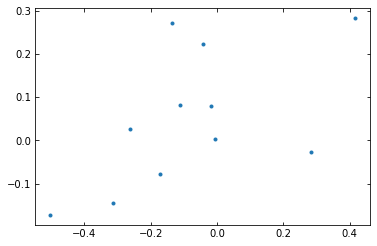

In [26]:
plt.plot(data.loc[:10, 'x_pos'], data.loc[:10, 'y_pos'],'.')